In [234]:
import pandas as pd
import random
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [200]:
codon_aa={'UUU':'Phe','UUC':'Phe','UUA':'Leu','UUG':'Leu','CUU':'Leu','CUC':'Leu','CUA':'Leu','CUG':'Leu','AUU':'Ile',
       'AUC':'Ile','AUA':'Ile','AUG':'Met','GUU':'Val','GUC':'Val','GUA':'Val','GUG':'Val','UCU':'Ser','UCC':'Ser',
       'UCA':'Ser','UCG':'Ser','CCU':'Pro','CCC':'Pro','CCA':'Pro','CCG':'Pro','ACU':'Thr','ACC':'Thr','ACA':'Thr',
       'ACG':'Thr','GCU':'Ala','GCC':'Ala','GCA':'Ala','GCG':'Ala','UAU':'Tyr','UAC':'Tyr','UAA':'STOP','UAG':'STOP',
       'CAU':'His','CAC':'His','CAA':'Gln','CAG':'Gln','AAU':'Asn','AAC':'Asn','AAA':'Lys','AAG':'Lys','GAU':'Asp',
       'GAC':'Asp','GAA':'Glu','GAG':'Glu','UGU':'Cys','UGC':'Cys','UGA':'STOP','UGG':'Trp','CGU':'Arg','CGC':'Arg',
       'CGA':'Arg','CGG':'Arg','AGU':'Ser','AGC':'Ser','AGA':'Arg','AGG':'Arg','GGU':'Gly','GGC':'Gly','GGA':'Gly',
       'GGG':'Gly'}

In [201]:
aa_counter = {
    'Pro' : [],
    'Ser' : [],
    'Ala' : [],
    'Thr' : [],
    'Leu' : [],
    'Phe' : [],
    'Val' : [],
    'Ile' : [],
    'Met' : [],
    'Arg' : [],
    'Cys' : [],
    'Trp' : [],
    'Gly' : [],
    'His' : [],
    'Gln' : [],
    'Tyr' : [],
    'Asp' : [],
    'Glu' : [],
    'Asn' : [],
    'Lys' : []
}

In [202]:
ref_data = pd.read_csv('../data/U_ideal_table.csv', index_col=0)

C:\Users\voron\AppData\Local\Temp\ipykernel_67132\1864407084.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ref_data = pd.read_csv('../data/U_ideal_table.csv', index_col=0)


In [203]:
ref_data = ref_data[ref_data['GenType'] == 'translated']

In [204]:
ref_data = ref_data[['CodonNumber', 'RefCodon']].drop_duplicates()

In [205]:
ref_data = ref_data[~(ref_data['RefCodon'].isin(['UGA', 'UAA', 'UAG']))]

In [206]:
ref_codon_list = ref_data['RefCodon'].to_list()

In [207]:
mutations = pd.read_csv('../data/All_mutation_information.csv.gz')
mutations = mutations[mutations['(SBS) is coding'].isin([True, 'TRUE', 'TRUE, TRUE'])]

C:\Users\voron\AppData\Local\Temp\ipykernel_67132\1688172839.py:1: DtypeWarning: Columns (13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_csv('../data/All_mutation_information.csv.gz')


In [208]:
all_df = mutations[mutations['base(s) in status 1'].isin(['A', 'T', 'G', 'C']) & mutations['base(s) in status 2'].isin(['A', 'T', 'G', 'C'])]

all_df['aa_from'] = all_df['(SBS) AA change'].str.split(" ").str[1].str[0]
all_df['aa_to'] = all_df['(SBS) AA change'].str.split(" ").str[1].str[0]
all_df = all_df.reset_index(drop=True)
all_df['counter'] = all_df.index
all_df['from_to_nuc'] = all_df['base(s) in status 1'] + '>' + all_df['base(s) in status 2']
data = all_df[['from_to_nuc', 'counter']].groupby(['from_to_nuc'], as_index=False).count()
n_mut = int(sum(data['counter']))
max_mut = int(max(data['counter']))
data['counter'] = data['counter']/n_mut

In [209]:
data['from_nuc'] = data['from_to_nuc'].str.split(">").str[0]
data['to_nuc'] = data['from_to_nuc'].str.split(">").str[1]
data['to_nuc'] = data['to_nuc'].str.replace('T','U')
data['from_nuc'] = data['from_nuc'].str.replace('T','U')

In [210]:
data

,from_to_nuc,counter,from_nuc,to_nuc
0,A>C,0.014415,A,C
1,A>G,0.088633,A,G
2,A>T,0.017136,A,U
3,C>A,0.021710,C,A
4,C>G,0.003897,C,G
5,C>T,0.468641,C,U
6,G>A,0.072942,G,A
7,G>C,0.012941,G,C
8,G>T,0.178431,G,U
9,T>A,0.013295,U,A


In [211]:
def select_codon_number(codon_list):
    return random.choice(range(len(codon_list)))

In [212]:
def mutate_codon(codon_number):
    nuc_number = random.choice(range(len(codon_list[codon_number])))
    
    nuc_spec = data[data['from_nuc'] == codon_list[codon_number][nuc_number]]
    pop = nuc_spec['to_nuc'].to_list()
    pop.append(codon_list[codon_number][nuc_number])
    
    wei = nuc_spec['counter'].to_list()
    wei.append(1 - sum(wei))
    
    new_nuc = random.choices(pop, weights=wei)[0]
    
    new_codon = codon_list[codon_number][:nuc_number] + new_nuc + codon_list[codon_number][nuc_number + 1:]
    
    if new_codon in ['UGA', 'UAA', 'UAG']:
        new_codon = codon_list[codon_number]
    
    codon_list[codon_number] = new_codon

In [213]:
def update_aa_dict(aa_counter, new_aa_counter):
    for key in aa_counter.keys():
        if key in new_aa_counter.keys():
            aa_counter[key].append(new_aa_counter[key])
        else:
            aa_counter[key].append(0)

In [214]:
codon_list = ref_codon_list

num_generations = 20000
mut_in_gen = 100

for gen in tqdm(range(num_generations)):
    new_dict = dict(Counter([codon_aa.get(item, item)  for item in codon_list]))
    
    update_aa_dict(aa_counter, new_dict)
    for mut in range(mut_in_gen):
        codon_num_to_mut = select_codon_number(codon_list)
        
        mutate_codon(codon_num_to_mut)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:39<00:00, 58.93it/s]


In [215]:
mutated_df = pd.DataFrame(aa_counter)
mutated_df = mutated_df / len(ref_codon_list)

In [216]:
mutated_df

,Pro,Ser,Ala,Thr,Leu,Phe,Val,Ile,Met,Arg,Cys,Trp,Gly,His,Gln,Tyr,Asp,Glu,Asn,Lys
0,0.040456,0.067871,0.067563,0.073724,0.095492,0.051340,0.080193,0.052572,0.021152,0.035835,0.030393,0.011397,0.059144,0.019407,0.037478,0.046001,0.052469,0.045282,0.054523,0.057706
1,0.040353,0.067666,0.067563,0.073313,0.095595,0.051853,0.079988,0.052880,0.021152,0.035835,0.030393,0.011295,0.059041,0.019407,0.037478,0.046001,0.052675,0.045179,0.054523,0.057809
2,0.040353,0.067769,0.067563,0.073211,0.095595,0.051751,0.079885,0.053291,0.021049,0.035733,0.030393,0.011295,0.059041,0.019407,0.037376,0.046206,0.052572,0.045385,0.054523,0.057603
3,0.040353,0.067871,0.067461,0.073005,0.095595,0.051751,0.079885,0.053599,0.020947,0.036041,0.030393,0.011295,0.058836,0.019407,0.037273,0.046103,0.052367,0.045590,0.054626,0.057603
4,0.040456,0.067769,0.067153,0.072903,0.095698,0.051956,0.079988,0.053907,0.020844,0.035835,0.030496,0.011192,0.058836,0.019407,0.037273,0.046103,0.052469,0.045693,0.054523,0.057501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.017148,0.096725,0.010165,0.018174,0.186056,0.329603,0.054215,0.086354,0.005853,0.013964,0.042920,0.003286,0.006469,0.013862,0.005237,0.074443,0.009755,0.002978,0.018277,0.004518
19996,0.017148,0.096622,0.010268,0.018277,0.185851,0.329911,0.054010,0.086251,0.005853,0.013964,0.043023,0.003286,0.006469,0.013964,0.005237,0.074340,0.009755,0.002978,0.018277,0.004518
19997,0.017148,0.096622,0.010268,0.018277,0.185851,0.329705,0.054215,0.086251,0.005853,0.014067,0.042920,0.003286,0.006469,0.013964,0.005237,0.074443,0.009652,0.002978,0.018277,0.004518
19998,0.017148,0.096725,0.010371,0.018277,0.185543,0.329911,0.054215,0.086148,0.005853,0.013964,0.043023,0.003286,0.006469,0.013862,0.005237,0.074546,0.009652,0.002978,0.018277,0.004518


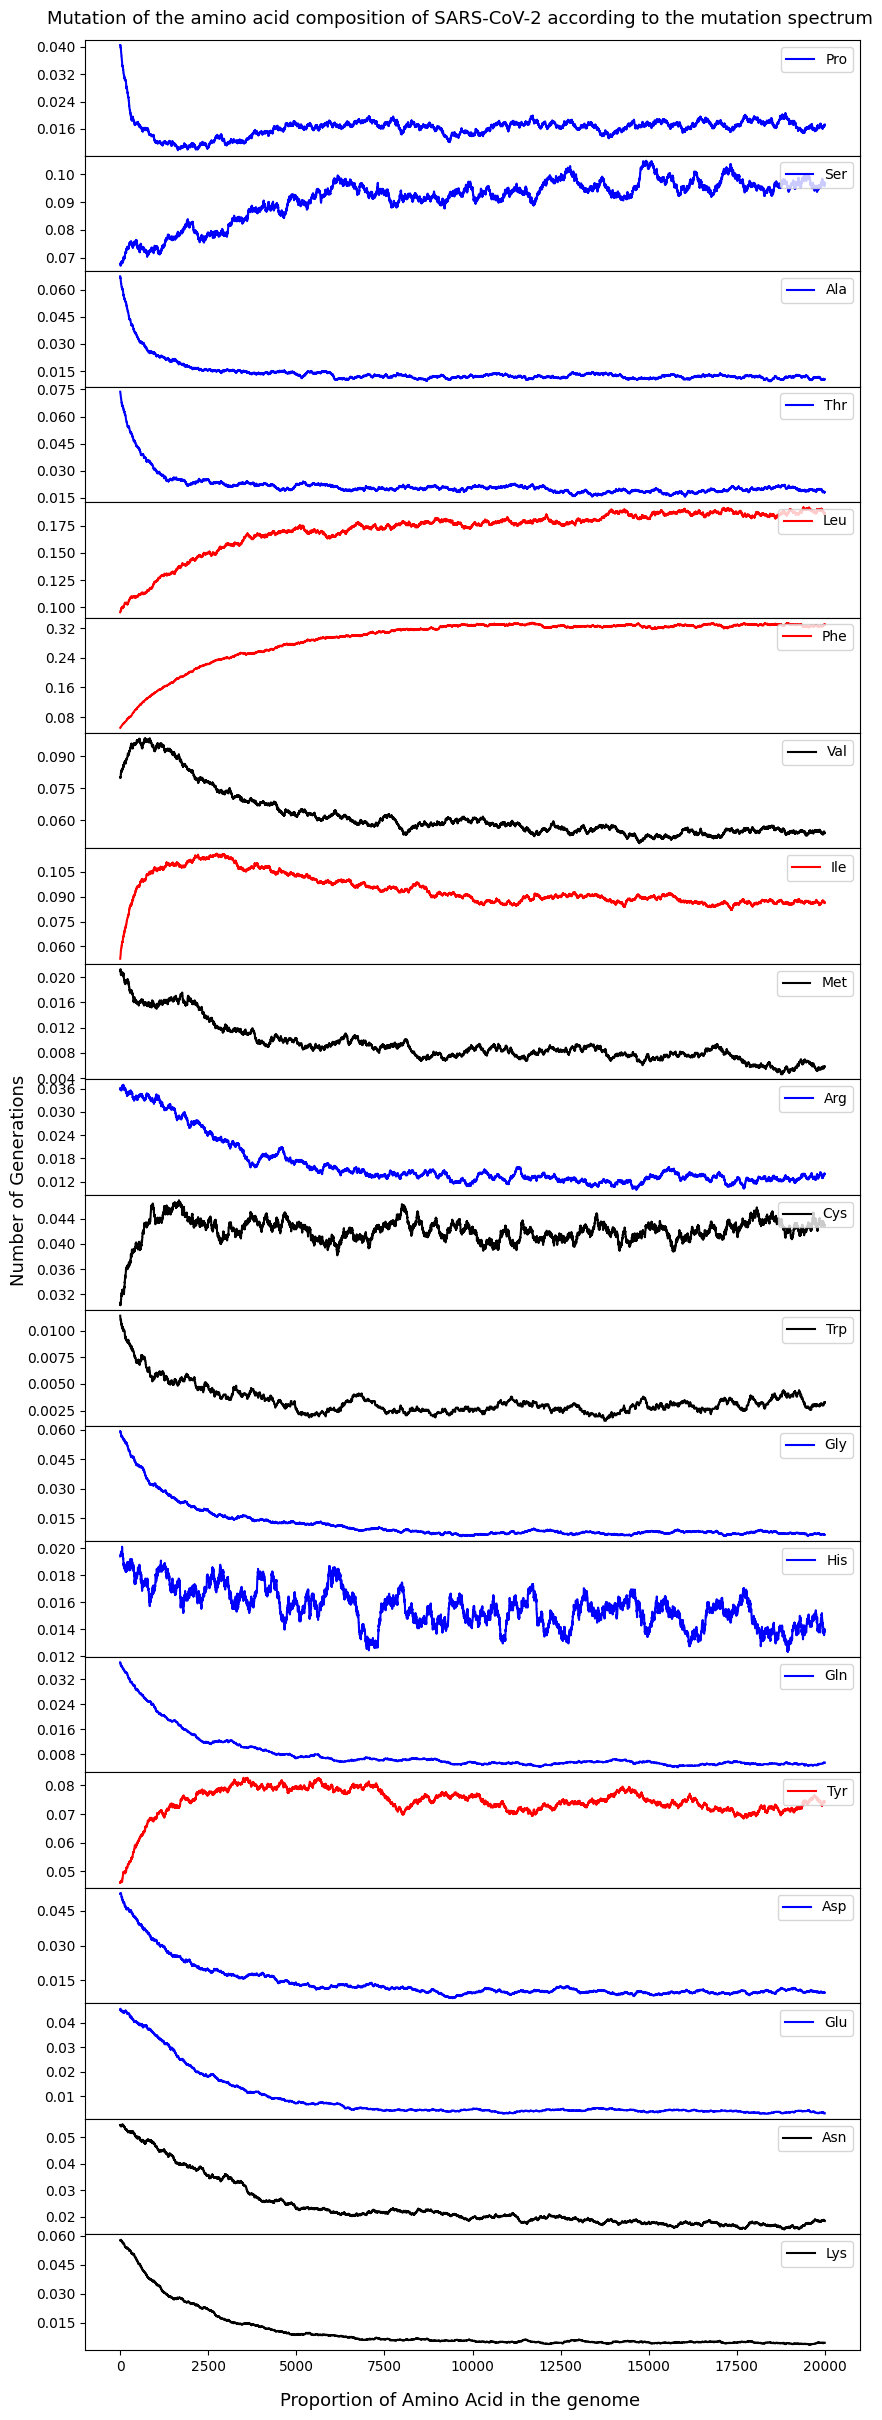

In [264]:
gainers = ['Phe', 'Leu', 'Tyr', 'Ile']
loosers = ['Pro', 'Ala', 'Gly', 'Arg', 'Thr', 'Ser', 'Arg', 'His', 'Gln', 'Asp', 'Glu']
with PdfPages('../figures/mutation_of_aa.pdf') as pdf:
    fig, axs = plt.subplots(20, figsize=(10, 30))

    for aa_num in range(len(mutated_df.columns)):
        aa = mutated_df.columns[aa_num]
        if aa in gainers:
            axs[aa_num].plot(mutated_df[aa], color='red', label=aa)
        elif aa in loosers:
            axs[aa_num].plot(mutated_df[aa], color='blue', label=aa)
        else:
            axs[aa_num].plot(mutated_df[aa], color='black', label=aa)

        axs[aa_num].legend(loc="upper right")
        axs[aa_num].yaxis.set_major_locator(plt.MaxNLocator(5))
    plt.subplots_adjust(hspace=0)
        
    plt.grid(False)
    fig.supxlabel("Proportion of Amino Acid in the genome", y=0.09, size=13)
    fig.supylabel("Number of Generations", x=0.05, size=13)
    fig.suptitle("Mutation of the amino acid composition of SARS-CoV-2 according to the mutation spectrum", y=0.89, size=13)
    pdf.savefig(fig, bbox_inches='tight') 